In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import math
import IPython.display as ipd

In [2]:
audio_path = r'dataset/raw/2243804495.mp3'

In [3]:
sampling_rate = 44100

In [4]:
#sample audio at 44.1 khz and get the time series as a numpy array
time_series, sampling_rate = librosa.load(audio_path, sr = sampling_rate)
#librosa.output.write_wav(r'dataset/processed/2243804495.wav', time_series, sampling_rate)
#trim empty start and end padding from time series
time_series, _ = librosa.effects.trim(time_series)

In [5]:
def draw_spectogram(spectogram_matrix):
    f = plt.figure(figsize=(10,5), dpi= 80)
    ax = f.add_subplot()
    ax.set_title('Mel-frequency spectrogram') #set title 
    mfcc = ax.matshow(spectogram_matrix, aspect="auto", cmap=plt.get_cmap('magma')) #draw matrix with colormap 'magma'
    ax.xaxis.set_ticks_position('bottom') #set x ticks to bottom of graph 
    ax.set_xlabel('Time (sec)')
    ax.invert_yaxis() #have y axis start from the bottom
    ax.set_ylabel('Hz')
    plt.tight_layout()
    plt.colorbar(mfcc, format='%+2.0f dB');
    plt.show()

# Sound Anlysis with Librosa

### amplitude vs time

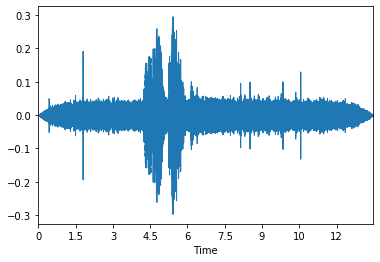

In [6]:
librosa.display.waveplot(time_series, sr=sampling_rate);

### Melspectogram with librosa

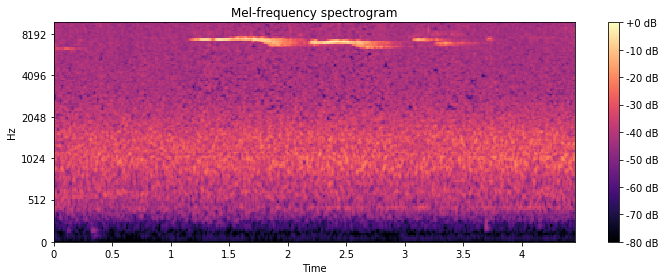

In [7]:
S = librosa.feature.melspectrogram(y=time_series[int(3*sampling_rate):int(7.5*sampling_rate)], sr=sampling_rate, n_mels=128, fmax=10000, center = False)
plt.figure(figsize=(10, 4))
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sampling_rate,
                         fmax=10000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

# Sound Analysis with Matplotlib and Numpy

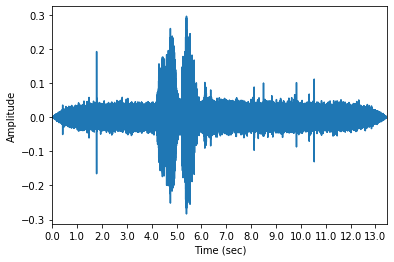

In [8]:
#plot with matplot 
fig, main_ax = plt.subplots()
main_ax.plot(time_series)
main_ax.set_xlim(left = 0, right = len(time_series))
main_ax.set_xticks(np.arange(0, len(time_series), step = sampling_rate))
main_ax.set_xticklabels(np.arange(0, len(time_series) / sampling_rate))
main_ax.set_xlabel('Time (sec)')
main_ax.set_ylabel('Amplitude')
plt.show()

## Mel Frequency Cepstral Coefficient (MFCC)

resources:

* [Mel Frequency Cepstral Coefficient (MFCC) tutorial by practical cryptography](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/)
* [Speech Processing for Machine Learning: Filter banks, Mel-Frequency Cepstral Coefficients (MFCCs) and What's In-Between](https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html)

### Steps:
1. Framing (splitting the signal into short frames)
1. Calculate the power spectrum
1. Apply filter banks

### 1. Framing

In [9]:
#split a time series into multiple frames given a window size and step size
def get_even_time_series_frames(time_series : np.array, window_size : int, step_size : int):
    #calculate number of frames (has to be an even number?)
    frame_num = (len(time_series) - window_size)/step_size + 1
    series = time_series #copy series
    if frame_num % 2 != 0:  #ensure that number of frames is a even number
        frame_num = math.ceil(frame_num / 2.0) * 2 #round number of frames to even number
        padding_len = (frame_num - 1) * step_size + window_size - len(time_series)  #calculate padding length 
        series = np.pad(series, (0, padding_len), 'constant') #pad end of series with 0s
    frame_num = int(frame_num)
    #create and return frames from rime series 
    return np.array([ series[step*step_size:step*step_size+window_size] for step in range(frame_num)])

In [10]:
def apply_hamming_window(frames : np.array):
    #Assumes that the length of the nth dimension is the length of a frame -> ex: 2d array shape (num_frames, frame_len)
    frames *= np.hamming(frames.shape[frames.ndim - 1])

def apply_hanning_window(frames : np.array):
    frames *= np.hanning(frames.shape[frames.ndim - 1])

In [11]:
def calculate_power_spectrum(time_series_frames, n_fft = None):
    mag_frames = np.abs(np.fft.rfft(time_series_frames, n_fft)) # for each frame compute the n point fourier transform 
    pow_frames = ((1.0 / n_fft) * ((mag_frames) ** 2))
    return pow_frames

In [12]:
def compute_real_fourier_transform(time_series_frames, n_fft = None):
    return np.fft.rfft(time_series_frames, n_fft)

In [13]:
#convert frequency to mel scale
def frequency_to_mel(freq):
    return 2595 * np.log10(1 + freq / 700)

#convert mel to frequency
def mel_to_frequency(mel):
    return 700 * (10 **(mel / 2595) - 1)

In [14]:
def apply_filter_banks(power_spectrum, sample_rate, n_fft, n_filters, freq_min = 0, freq_max = 22050):
    #convert min and max frequency to mel scale
    min_mel = frequency_to_mel(freq_min)
    max_mel = frequency_to_mel(freq_max)
    #create linearly spaced points between the min and max mel
    mel_points = np.linspace(min_mel, max_mel, n_filters + 2)
    #convert mel points back to hz
    freq_points = mel_to_frequency(mel_points)
    #round frequency points to nearest fourier transform bin (n_fft)
    freq_bins = np.floor((n_fft + 1) * freq_points / sample_rate).astype(int)

    fbank = np.zeros((n_filters, int(np.floor(n_fft / 2 + 1))))
    for m in range(1, n_filters + 1):
        filter_bank_start = freq_bins[m - 1]
        filter_bank_max   = freq_bins[m]
        filter_bank_end   = freq_bins[m + 1]

        for k in range(filter_bank_start, filter_bank_max):
            #print(k)
            fbank[m - 1, k] = (k - freq_bins[m - 1]) / (freq_bins[m] - freq_bins[m - 1])
        for k in range(filter_bank_max, filter_bank_end):
            fbank[m - 1, k] = (freq_bins[m + 1] - k) / (freq_bins[m + 1] - freq_bins[m])

    filter_banks = np.dot(power_spectrum, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    #

    return filter_banks

(1158, 2048)
(1158, 1025)


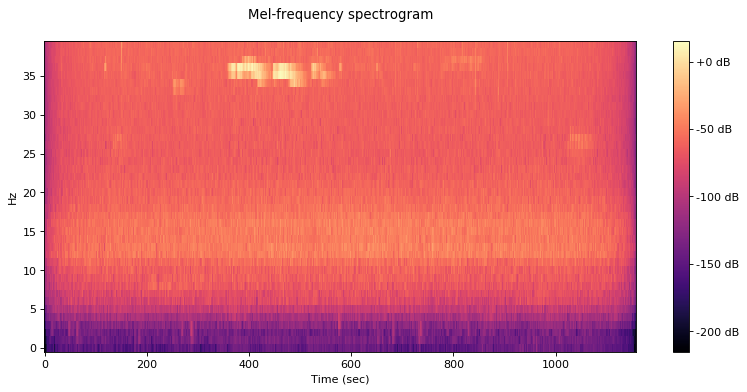

In [15]:
window_size_ms = 25
step_size_ms = 10
sample_rate = 44100
frame_length = int(.001 * window_size_ms * sampling_rate)
step_size = int(.001 * step_size_ms * sampling_rate)
#print(frame_length, step_size)

frame_length = 2048
step_size = 512

n_fft = 2048
bands = 40
#print(frame_length, step_size)

time_series_frames = get_even_time_series_frames(time_series, frame_length, step_size)
print(time_series_frames.shape)

apply_hanning_window(time_series_frames)
pow_frames = calculate_power_spectrum(time_series_frames, n_fft)
print(pow_frames.shape)

#print(pow_frames.shape)
filter_banks = apply_filter_banks(pow_frames, sample_rate, n_fft, bands, freq_max= 10000)
filter_banks = 20 * np.log10(filter_banks)  # dB
#print(filter_banks.shape)
#filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)
f = plt.figure(figsize=(10,5), dpi= 80)
ax = f.add_subplot()
ax.set_title('Mel-frequency spectrogram') #set title 
mfcc = ax.matshow(filter_banks.T, aspect="auto", cmap=plt.get_cmap('magma')) #draw matrix with colormap 'magma'
ax.xaxis.set_ticks_position('bottom') #set x ticks to bottom of graph 
ax.set_xlabel('Time (sec)')
#ax.set_xticks(np.arange(0, len(time_series), step = sampling_rate))
#ax.set_xticklabels(np.arange(0, len(time_series) / sampling_rate))
ax.invert_yaxis() #have y axis start from the bottom
ax.set_ylabel('Hz')
y_tick_stepsize = 1000
#ax.set_yticks(np.arange(0, max_frequency / y_tick_stepsize, step = y_tick_stepsize))
#ax.set_yticklabels(np.arange(0, max_frequency / y_tick_stepsize))
plt.tight_layout()
plt.colorbar(mfcc, format='%+2.0f dB');
plt.show()
#get_fourier_transform(time_series, sampling_rate)

In [16]:
#sample audio at 44.1 khz and get the time series as a numpy array
time_series, sampling_rate = librosa.load(audio_path, sr = sampling_rate)
#trim empty start and end padding from time series
time_series, _ = librosa.effects.trim(time_series)

In [17]:

time_series_frames = get_even_time_series_frames(time_series, 2048, 512)

In [18]:
#sample audio at 44.1 khz and get the time series as a numpy array
time_series, sampling_rate = librosa.load(audio_path, sr = sampling_rate)
#trim empty start and end padding from time series
time_series, _ = librosa.effects.trim(time_series)

In [19]:
import scipy
lib_frames = librosa.util.frame(time_series, 2048, 512)
lib_frames = lib_frames.T

In [20]:
print((lib_frames == time_series_frames).all())
print(np.array_equal(lib_frames, time_series_frames))
print('librosa: {} own: {}'.format(lib_frames.shape, time_series_frames.shape))

True
True
librosa: (1158, 2048) own: (1158, 2048)


In [21]:
#time_series_frames *= scipy.signal.hanning(2048, sym = False)
time_series_frames *= np.hanning(2048)


In [22]:
time_series_frames.shape

(1158, 2048)

In [23]:
time_series_frames

array([[ 0.0000000e+00,  6.4345418e-11, -1.8208308e-10, ...,
        -8.8441459e-09, -6.9266437e-10,  0.0000000e+00],
       [-0.0000000e+00,  6.6895944e-10,  1.5744341e-09, ...,
        -7.4689760e-10, -1.9729618e-09, -0.0000000e+00],
       [ 0.0000000e+00,  1.0416602e-09,  4.6723088e-09, ...,
        -1.3160025e-08, -1.7717967e-09,  0.0000000e+00],
       ...,
       [-0.0000000e+00,  2.3546969e-09, -4.1040118e-09, ...,
        -4.0574610e-09,  2.7355253e-11,  0.0000000e+00],
       [-0.0000000e+00, -8.4055174e-10, -6.9718391e-09, ...,
         7.4904943e-10, -2.1782627e-10, -0.0000000e+00],
       [-0.0000000e+00, -2.0401127e-09, -1.0185692e-09, ...,
         6.1189491e-12, -8.1371880e-12, -0.0000000e+00]], dtype=float32)

In [24]:
lib_frames *= np.hanning(2048)

In [25]:
lib_frames.shape

(1158, 2048)

In [26]:
lib_frames

array([[ 0.0000000e+00,  6.4345418e-11, -1.8208308e-10, ...,
        -4.6539510e-04, -1.4624803e-04,  3.1221560e-05],
       [-0.0000000e+00,  6.6895944e-10,  1.5744341e-09, ...,
        -3.9303115e-05, -4.1656793e-04, -5.5727578e-04],
       [ 0.0000000e+00,  1.0416602e-09,  4.6723088e-09, ...,
        -6.9250452e-04, -3.7409429e-04,  4.7245034e-04],
       ...,
       [-0.0000000e+00,  2.3546969e-09, -4.1040118e-09, ...,
        -4.3065083e-04,  1.1613810e-05,  1.9401343e-05],
       [-0.0000000e+00, -8.4055174e-10, -6.9718391e-09, ...,
         4.0026429e-05, -4.6417277e-05, -6.9291855e-05],
       [-0.0000000e+00, -2.0401127e-09, -1.0185692e-09, ...,
         6.1189491e-12, -8.1371880e-12, -0.0000000e+00]], dtype=float32)

In [27]:
lib_mag_frames = np.abs(np.fft.rfft(lib_frames, 2048))

In [28]:
lib_pow_frames = ((1.0 / 2048) * ((lib_mag_frames) ** 2))
mel = librosa.filters.mel(sr=sampling_rate, n_fft=2048, n_mels=128, fmax=10000)
mel_frames = mel.dot(lib_pow_frames)
melFrames_db = librosa.power_to_db(mel_frames, ref=np.max)

ValueError: shapes (128,1025) and (1158,1025) not aligned: 1025 (dim 1) != 1158 (dim 0)

In [29]:
draw_spectogram(melFrames_db)

NameError: name 'melFrames_db' is not defined

In [30]:
lib_frames

array([[ 0.0000000e+00,  6.4345418e-11, -1.8208308e-10, ...,
        -4.6539510e-04, -1.4624803e-04,  3.1221560e-05],
       [-0.0000000e+00,  6.6895944e-10,  1.5744341e-09, ...,
        -3.9303115e-05, -4.1656793e-04, -5.5727578e-04],
       [ 0.0000000e+00,  1.0416602e-09,  4.6723088e-09, ...,
        -6.9250452e-04, -3.7409429e-04,  4.7245034e-04],
       ...,
       [-0.0000000e+00,  2.3546969e-09, -4.1040118e-09, ...,
        -4.3065083e-04,  1.1613810e-05,  1.9401343e-05],
       [-0.0000000e+00, -8.4055174e-10, -6.9718391e-09, ...,
         4.0026429e-05, -4.6417277e-05, -6.9291855e-05],
       [-0.0000000e+00, -2.0401127e-09, -1.0185692e-09, ...,
         6.1189491e-12, -8.1371880e-12, -0.0000000e+00]], dtype=float32)

In [31]:
np.array_equal(lib_frames, time_series_frames.T)

False

In [32]:
lib_frames.shape

(1158, 2048)

## Melspectogram with librosa step by step

In [33]:
#sample audio at 44.1 khz and get the time series as a numpy array
time_series, sampling_rate = librosa.load(audio_path, sr = sampling_rate)
#trim empty start and end padding from time series
time_series, _ = librosa.effects.trim(time_series)

In [34]:
lib_mag_frames = np.abs(librosa.stft(time_series, n_fft = 2048, hop_length = 512, center = False))
lib_pow_frames = ((1.0 / 2048) * ((lib_mag_frames) ** 2))
melFrames_db_2 = librosa.power_to_db(lib_pow_frames, ref=np.max)



lib_pow_frames.shape

(1025, 1158)

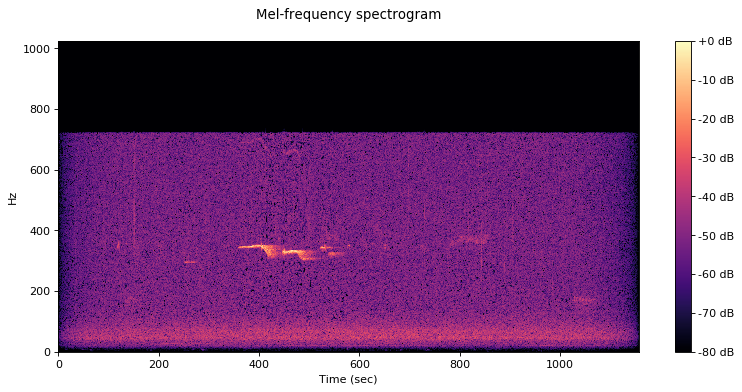

In [35]:
draw_spectogram(melFrames_db_2)

In [36]:
lib_mag_frames

array([[2.2402933e-04, 1.1933121e-06, 3.2900291e-04, ..., 1.2254840e-04,
        1.9352778e-04, 5.7461632e-05],
       [2.1114651e-04, 3.3656979e-04, 2.4714629e-04, ..., 6.1552440e-05,
        2.7671969e-04, 2.3861104e-04],
       [3.1178317e-04, 3.6636740e-04, 1.7600073e-04, ..., 2.7443035e-04,
        3.6710568e-04, 2.9912929e-04],
       ...,
       [3.2945686e-06, 3.4555085e-06, 1.3998186e-06, ..., 4.7971143e-06,
        2.3004675e-06, 1.2961734e-06],
       [3.1601080e-06, 3.4751299e-06, 1.8785854e-06, ..., 3.3065062e-06,
        3.7398509e-06, 1.6840803e-06],
       [2.6650898e-06, 5.0329713e-06, 4.9312298e-06, ..., 3.2665134e-06,
        3.6351662e-06, 5.0393680e-08]], dtype=float32)

In [37]:
mel = librosa.filters.mel(sr=sampling_rate, n_fft=2048, n_mels=128, fmax=10000)

In [38]:
mel_frames = mel.dot(lib_pow_frames)
melFrames_db_2 = librosa.power_to_db(mel_frames, ref=np.max)

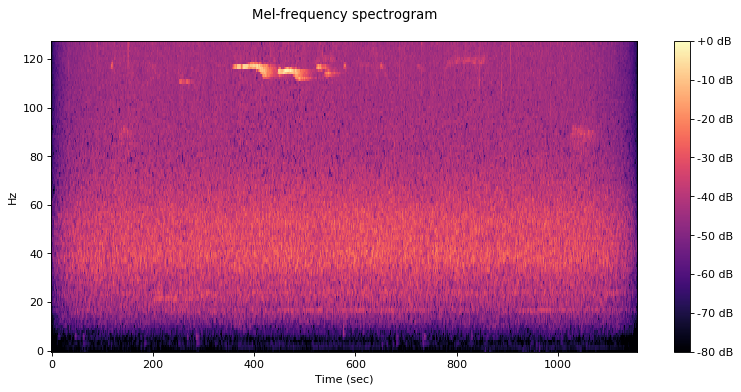

In [39]:
draw_spectogram(melFrames_db_2)

## Melspectogram with matplotlib for plotting

In [40]:
#sample audio at 44.1 khz and get the time series as a numpy array
time_series, sampling_rate = librosa.load(audio_path, sr = sampling_rate)
#trim empty start and end padding from time series
time_series, _ = librosa.effects.trim(time_series)

(128, 1158)


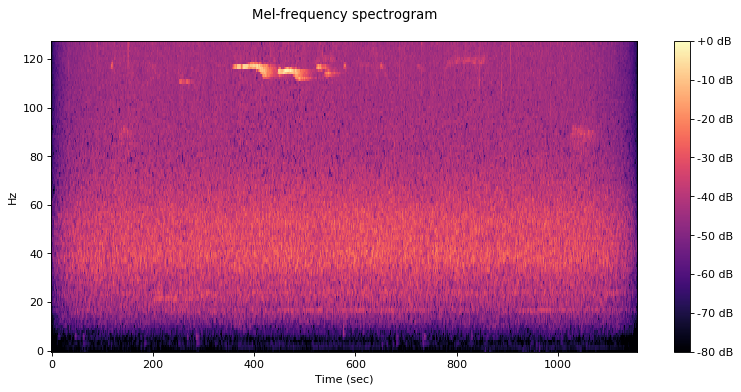

In [41]:
n_mels = 128
max_frequency = 10000

S = librosa.feature.melspectrogram(y=time_series, sr=sampling_rate, n_mels=n_mels, fmax=max_frequency, center = False)
S_dB = librosa.power_to_db(S, ref=np.max)
print(S_dB.shape)

f = plt.figure(figsize=(10,5), dpi= 80)
ax = f.add_subplot()
ax.set_title('Mel-frequency spectrogram') #set title 
mfcc = ax.matshow(S_dB, aspect="auto", cmap=plt.get_cmap('magma')) #draw matrix with colormap 'magma'
ax.xaxis.set_ticks_position('bottom') #set x ticks to bottom of graph 
ax.set_xlabel('Time (sec)')
#ax.set_xticks(np.arange(0, len(time_series), step = sampling_rate))
#ax.set_xticklabels(np.arange(0, len(time_series) / sampling_rate))
ax.invert_yaxis() #have y axis start from the bottom
ax.set_ylabel('Hz')
y_tick_stepsize = 1000
#ax.set_yticks(np.arange(0, max_frequency / y_tick_stepsize, step = y_tick_stepsize))
#ax.set_yticklabels(np.arange(0, max_frequency / y_tick_stepsize))
plt.tight_layout()
plt.colorbar(mfcc, format='%+2.0f dB');
plt.show()